In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
df = pd.read_csv('C:/PSL_KNN/data_with_fingers.csv')

In [8]:
##tiene que quedar solo los fingers validos
## tbm eliminar la clase KNN
#revisar integridad de datos respecto a las clase "adulto" y " adulto"

In [9]:
df.shape

(1481250, 6)

In [10]:
df = df.loc[df["class"]!="NNN"].reset_index(drop=True)

In [11]:
#landmark_to_drop = [23,24,25,26,27,28,29,30,31,32]

In [13]:
'''
for i in range(len(df)): 
    if (df['n_landmark'][i] in landmark_to_drop) :
        df.drop([i], axis=0, inplace=True)
'''

"\nfor i in range(len(df)): \n    if (df['n_landmark'][i] in landmark_to_drop) :\n        df.drop([i], axis=0, inplace=True)\n"

In [20]:
df = df.loc[(df['n_landmark'] <= 21) | (df['n_landmark'] >= 33)]
df

,videoname,n_frame,n_landmark,x,y,class
0,A-L-E-X_271,0,0,0.464181,0.202892,A-L-E-X
1,A-L-E-X_271,0,1,0.487545,0.165676,A-L-E-X
2,A-L-E-X_271,0,2,0.502058,0.165084,A-L-E-X
3,A-L-E-X_271,0,3,0.515145,0.165213,A-L-E-X
4,A-L-E-X_271,0,4,0.439742,0.170089,A-L-E-X
...,...,...,...,...,...,...
1459645,él_816,6,70,0.295229,0.438789,él
1459646,él_816,6,71,0.274236,0.417244,él
1459647,él_816,6,72,0.287305,0.417189,él
1459648,él_816,6,73,0.288845,0.429033,él


In [21]:
df.to_csv("C:/PSL_KNN/data_with_fingers_valid.csv")

In [22]:
df = pd.read_csv('C:/PSL_KNN/data_with_fingers_valid.csv')

In [ ]:
#data_with_fingers.drop(data_with_fingers[data_with_fingers.n_landmark == 34].index, inplace=True)

In [ ]:
#df['class'] = df['videoname'].apply(lambda x: x.split('_')[0])

In [24]:
import math
min_frames = 5

In [29]:
df_or = df[['videoname', 'n_frame', 'n_landmark', 'x', 'y', 'class']]

In [30]:
df_or.head()

,videoname,n_frame,n_landmark,x,y,class
0,A-L-E-X_271,0,0,0.464181,0.202892,A-L-E-X
1,A-L-E-X_271,0,1,0.487545,0.165676,A-L-E-X
2,A-L-E-X_271,0,2,0.502058,0.165084,A-L-E-X
3,A-L-E-X_271,0,3,0.515145,0.165213,A-L-E-X
4,A-L-E-X_271,0,4,0.439742,0.170089,A-L-E-X


In [31]:
### COMMENTING

df_or_nframes = df_or.groupby("videoname").agg({"n_frame": "nunique"}).rename(columns={"n_frame": "n_frames"})
df_or = df_or.join(df_or_nframes, on="videoname")


Filter: min number of frames
Shape (1242304, 7) - N classes 355  - Number of videos 1069


<AxesSubplot:>

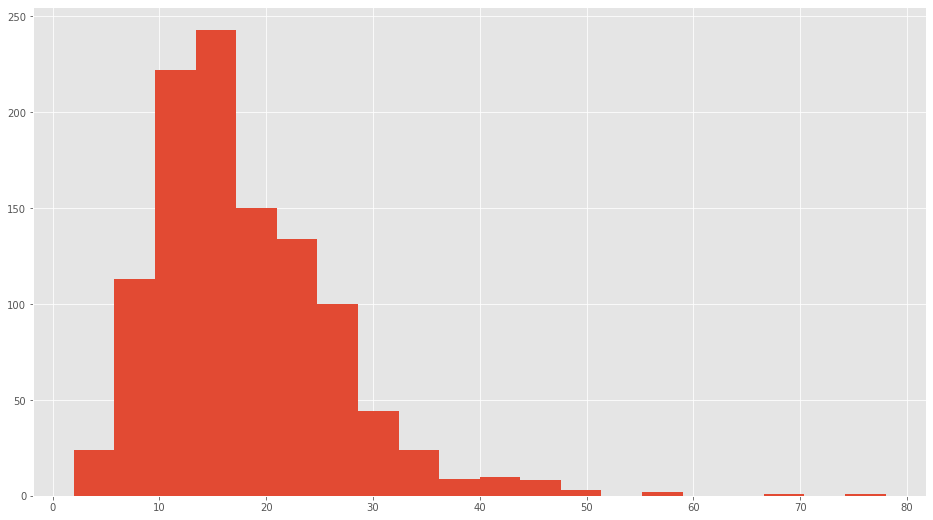

In [34]:
# at least 10 or 15 frames
df_or_nframes.reset_index().n_frames.hist(bins=20)

In [35]:
df_or = df_or.join(df_or_nframes, on="videoname")
df_or.head(2)

ValueError: columns overlap but no suffix specified: Index(['n_frames'], dtype='object')

In [ ]:
df_or.loc[df_or.n_frames>=10].videoname.nunique()

In [ ]:
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
      " - Number of videos", df_or["videoname"].nunique())

In [ ]:
# applying filters - n frames
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
      " - Number of videos", df_or["videoname"].nunique())

print()
print("Filter: min number of frames")
df_or = df_or.loc[df_or.n_frames>=10]
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
      " - Number of videos", df_or["videoname"].nunique())


In [ ]:
df_or.groupby("videoname").agg({"n_frame": "nunique"}).rename(columns={"n_frame": "n_frames"}).describe()

In [32]:
xd = df_or.groupby(["videoname", "n_frame"]).agg({"n_frames": "first"})
xd['rate'] = xd['n_frames'].apply(lambda x: math.ceil(x/min_frames))
xd = xd.reset_index()
xd['valid_frame?'] = xd['n_frame'] % xd['rate'] == 0
xd['missing_frames'] = min_frames - xd['n_frames'].apply(lambda x: math.ceil(x/math.ceil(x/min_frames))) 
        
xd_valid = xd.loc[(~xd['valid_frame?']) &
                            (xd.missing_frames>0)]
xd_valid['row_number_video'] = xd_valid.groupby(['videoname'])['n_frame'].cumcount() + 1 

xd_valid['upper_value'] = xd_valid.apply(lambda x: math.floor((x['n_frames'] - (min_frames - x['missing_frames']))/2) 
                                                   + x['missing_frames'] - math.floor(x['missing_frames']/2), axis=1)
xd_valid['lower_value'] = xd_valid.apply(lambda x: math.floor((x['n_frames'] - (min_frames - x['missing_frames']))/2) 
                                                        - math.floor(x['missing_frames']/2), axis=1)

xd_valid.loc[((xd_valid['lower_value']<xd_valid['upper_value']) & 
                    (xd_valid['row_number_video']>xd_valid['lower_value']) & 
                    (xd_valid['row_number_video']<=xd_valid['upper_value']))|
                    ((xd_valid['lower_value']==xd_valid['upper_value']) &
                    (xd_valid['row_number_video']==xd_valid['upper_value'])), 'valid_frame?'] = True

xd = xd.merge(xd_valid[['videoname', 'n_frame', 'valid_frame?']].rename(columns={'valid_frame?': 'valid_frame2?'}),
                        how='left', on=['videoname', 'n_frame'])
xd.loc[(~xd['valid_frame?']) & 
                (xd['valid_frame2?']), 'valid_frame?'] = xd['valid_frame2?']

df_or = df_or.join(xd.set_index(['videoname', 'n_frame'])["valid_frame?"], on=['videoname', 'n_frame'])

C:\Users\BRENDA\AppData\Local\Temp\ipykernel_864\1615796107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xd_valid['row_number_video'] = xd_valid.groupby(['videoname'])['n_frame'].cumcount() + 1
C:\Users\BRENDA\AppData\Local\Temp\ipykernel_864\1615796107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xd_valid['upper_value'] = xd_valid.apply(lambda x: math.floor((x['n_frames'] - (min_frames - x['missing_frames']))/2)
C:\Users\BRENDA\AppData\Local\Temp\ipykernel_864\1615796107.py:13: SettingWithCo

In [33]:
df_or

,videoname,n_frame,n_landmark,x,y,class,n_frames,valid_frame?
0,A-L-E-X_271,0,0,0.464181,0.202892,A-L-E-X,23,True
1,A-L-E-X_271,0,1,0.487545,0.165676,A-L-E-X,23,True
2,A-L-E-X_271,0,2,0.502058,0.165084,A-L-E-X,23,True
3,A-L-E-X_271,0,3,0.515145,0.165213,A-L-E-X,23,True
4,A-L-E-X_271,0,4,0.439742,0.170089,A-L-E-X,23,True
...,...,...,...,...,...,...,...,...
1245563,él_816,6,70,0.295229,0.438789,él,7,True
1245564,él_816,6,71,0.274236,0.417244,él,7,True
1245565,él_816,6,72,0.287305,0.417189,él,7,True
1245566,él_816,6,73,0.288845,0.429033,él,7,True


In [ ]:
df['videoname'] = df['videoname'].apply(lambda x: x.strip())

In [ ]:
#df
#df.loc[df['class'] == ' adulto']

In [ ]:
df.groupby('class')['videoname'].count()

class
 adulto                       2625
 ustedes                      1275
A-L-E-X                       3450
A-N-D-R-E-A                   3300
C A R B O H I D R A T O S     6300
                             ...  
voltear                        900
volver                        1575
ya                            6375
yo                           21150
él                           19200
Name: videoname, Length: 361, dtype: int64

In [ ]:
### poner las clases con las que me quedaría eg. yo, él
#
#crear unacolumna y ponerle el valor ahí, cuando hice contar


In [ ]:
array = df['videoname'].unique()
#df_or["videoname"].nunique()

#df_or.loc[df_or.n_instances>=min_instances].reset_index(drop=True)

In [ ]:
array

array(['A-L-E-X_271', 'A-L-E-X_275', 'A-N-D-R-E-A_236', ..., 'él_524',
       'él_717', 'él_816'], dtype=object)

In [ ]:
'''
dic = {}
for i in range(13000,13500):
    maricucha = (df['videoname'][i].split("_")[0])
    if maricucha not in dic:
        dic[maricucha] = 1
    else:
        dic[maricucha] += 1

print(dic)
'''

'\ndic = {}\nfor i in range(13000,13500):\n    maricucha = (df[\'videoname\'][i].split("_")[0])\n    if maricucha not in dic:\n        dic[maricucha] = 1\n    else:\n        dic[maricucha] += 1\n\nprint(dic)\n'

In [ ]:
#for i in range(1,20):
#    print(type(i))


In [ ]:
#df['class'].value_counts()

In [ ]:
#df['class'].unique()

In [ ]:
df['videoname'].unique()

array(['A-L-E-X_271', 'A-L-E-X_275', 'A-N-D-R-E-A_236', ..., 'él_524',
       'él_717', 'él_816'], dtype=object)

In [ ]:
dic = {}
for i in df['videoname'].unique():
    temp = i.split("_")[0]
    if temp not in dic:
        dic[temp] = 1
    else:
        dic[temp] += 1

#print(dic)
#dic.keys()

#n_instances

#A-L-E-X 2

#solo agarrame los que tienen más de dos instancias
#como columna en el dataframe
sort_orders = sorted(dic.items(), key=lambda x: x[1], reverse=False)

for key,value in sort_orders:
    print(key,value)

'''
min_instancias = 4 
min_instancias = 2
min_instancias=50  -> solo agarra las clases 50 y 52

'''


A-N-D-R-E-A 1
acuerdo 1
alrededor 1
asco 1
avanzar 1
bienvenida 1
bonito 1
buscar 1
contenta 1
convivencia 1
cualquiera 1
cumplir 1
descubrir 1
dia 1
diez 1
difícil 1
doce 1
dormir 1
educación 1
enojo 1
explicar 1
faltar 1
ganar 1
gracias 1
gritar 1
hasta 1
hermanos 1
historia 1
identificar 1
impaciente 1
inteligente 1
ir 1
llorar 1
lugar 1
mañana 1
mejor 1
menos 1
miedo 1
mismos 1
mundo 1
normal 1
P-A-T-I 1
P-A-T-R-I-C-I-A 1
P-U-B-E-R-T-A-D 1
perder 1
poner 1
por qué 1
positivo 1
problema 1
propia 1
pubertad 1
querer 1
recuerdas 1
resolver 1
seguir 1
siguiente 1
silencio 1
sorpresa 1
tristeza 1
título 1
unir 1
abrir 1
alimento 1
andar 1
animal 1
anotar 1
aproximado 1
atención 1
aumentar 1
avisar 1
ayudarme 1
ayudarte 1
ayudar 1
balancear 1
bienvenido 1
brotar planta 1
bueno 1
C E S Y 1
C H A R Q UI 1
C H A 1
cantidad 1
cerdo 1
cinco 1
cincuenta 1
colegio 1
comunidad 1
conservada 1
contar 1 1
cosas 1
cuadricula 1
cuadrícula 1
cuatro 1
cubrir 1
cuáles 1
cuándo 1
darte 1
dar 1
decirme 1


'\nmin_instancias = 4 \nmin_instancias = 2\nmin_instancias=50  -> solo agarra las clases 50 y 52\n\n'

In [ ]:
#sort_dict= dict(sorted(dic.items(), key=lambda item: item[1]))


In [ ]:

'''
temp = []
index = 0
for key,value in dic.items():
    if value >= 2:
        temp.append(key)
print(temp)

for i in df['class']: 
    print(i)
    if i not in temp:
        df.drop([index], inplace=True)
        
    index += 1
'''

['A-L-E-X', 'abuelo', 'aceptar', 'ahora', 'ahí', 'alegría', 'ambiente', 'amigo', 'antes', 'aprender', 'aquí', 'bien', 'cambiar', 'casa', 'controlar', 'crecer', 'cuando', 'cuerpo', 'cómo', 'decir', 'dejar', 'dentro', 'dibujar', 'dos', 'día', 'edad', 'emoción', 'empezar', 'enojar', 'entender', 'familia', 'feliz', 'habitación', 'hacer', 'hermano', 'hola', 'hoy', 'idea', 'ira', 'jugar', 'juntos', 'M-A-R-C-O', 'mamá', 'manejar', 'ministerio', 'mi', 'mostrar', 'más o menos', 'más', 'necesitar', 'NNN', 'nombre', 'nosotros', 'no', 'objetivo', 'paciencia', 'papá', 'pensar', 'poder', 'preguntar', 'primaria', 'primo', 'profesor', 'que', 'quien', 'quinto', 'quién', 'qué', 'razón', 'recordar', 'regla', 'relación', 'seguro', 'seleccionar', 'semana', 'sentir', 'sexto', 'sí', 'también', 'tener', 'tiempo', 'tú', 'unión', 'uno', 'usar', 'ustedes', 'venir', 'yo', 'adulto', 'adentro', 'agrupar', 'agua', 'alimentos', 'amarrar', 'animales', 'aproximadamente', 'beneficio', 'botar', 'brotar', 'buen', 'C A R B

KeyboardInterrupt: 

In [ ]:
#df[df['class'] not in temp]
#df.drop(df[df['class'] != temp].index, inplace = True)


ValueError: ('Lengths must match to compare', (1480039,), (2,))

In [ ]:
#df.groupby("class").agg({"videoname": "nunique"}).videoname.nunique()==1

In [ ]:
#### AHORA LO QUE QUIERO ES COMPARAR ??
'''
The number of instances does not matter, the minimum is 2. 

The number of frames does not matter either? 
I mean, it doesn't matter if one has 1 frame and the other has more than 15 frames? 
1 frame would mean that it only has 1 image, but with one image
is the duration of the video, let's assume that all of them have a duration more or less ....

now what you want is to have the same classes

in both pose_only and 


n_frame 
n_component
k 

without taking n_frame, in both datasets. which classes are the same? is that what you want?

IT HAS NOT YET BEEN TESTED BY CHANGING THE LENGTH FOR EXAMPLE

IF YOU DELETE THE ONES WITH 1 INSTANCE, YOU ARE REMOVING 193 CLASSES
IF YOU DELETE THE ONES WITH 2 INSTANCES, YOU ARE REMOVING 68 CLASSES
IF YOU DELETE THOSE WITH 3 INSTANCES, YOU ARE REMOVING 28 CLASSES
IF YOU DELETE THOSE WITH 4 INSTANCES, YOU ARE DELETING 20 CLASSES
IF YOU DELETE THOSE WITH 5 INSTANCES, YOU ARE DELETING 5 CLASSES
IF YOU DELETE THOSE WITH 6 INSTANCES, YOU ARE DELETING 9 CLASSES
IF YOU DELETE THE ONES WITH 7 INSTANCES, YOU ARE REMOVING 5 CLASSES


--> Maybe in the sign language, these 3 you are different, 

ayudar
ayudarme
ayudarte

 and so you are considering it as 3 different classes, otherwise, you could re-label all of them to fit our model 

 ##CASES FOUND


 P-A-T-I
P-A-T-R-I-C-I-A
PA	T	R	I	C	I	A


ayudarme
ayudarte

cuadricula
cuadrícula

darte
dar

esos
eso

información
informar

juntarse
junto

P	R	P	R	O	T	E	I	N	A	S
P	R	P	R	O	T	E	I	N	A	

padre
papas fritas
papa
papá


pedirte
pedir

priimero
primero

siguiente	
siguiente	cinco
siguiente	cuatro
siguiente	dos
siguiente	tres


quien 2
quién 2


ACCORDING TO THE GRAPH WE CAN SEE THAT MOST OF THEM HAVE BETWEEN 10 AND 20 FRAMES, when we were setting it to have exactly 10 frames, we were being very restrictive. 

NEXT SETP: run the KNN model with the dtaa we get and see how it separates 75% and 25%.


the most restrictive experiemnt allow me to have just 3 clsses, we would like to know about the 

so what about length? 
'''

